# Particle system simulation and fitting

This tours shows how to use [PyTorch](https://pytorch.org/) and [Keops](https://www.kernel-operations.io/keops/index.html) to compute the evolution of a particles system with a simple interaction energy. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time
import progressbar

Check if cuda is available (be sure to go to the parameter of the notebook to activate GPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Draw random particles.

In [ ]:
n = 10000 # number of points
m = 10100 # number of points on the second cloud
d = 2 # dimension
X = torch.rand(n,d)
Y = torch.rand(m,d)
print( X.is_cuda )
X = X.to(device); # put it on gpu
Y = Y.to(device); # put it on gpu
print( X.is_cuda )

False
True


Handling boundary conditions.

Periodic boundary.


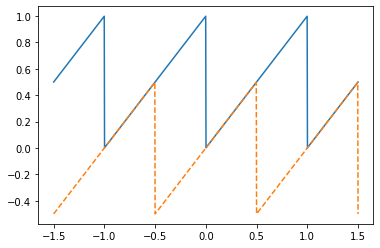

In [ ]:
boundary = 'no' # no boundary condition
boundary = 'per' # periodic 
if boundary=='no': # change this for usual BC
  print('No boundary.')
  def bc_pos(X): return X
  def bc_diff(D): return D
else:
  print('Periodic boundary.')
  def bc_pos(X): return torch.remainder(X,1.0)
  def bc_diff(D): return torch.remainder(D-.5,1.0)-.5

t = torch.tensor(np.linspace(-1.5,1.5,1000))
plt.plot( t, bc_pos( t ) )
plt.plot( t, bc_diff( t ), '--' )

Example of how to compute a pairwise distance matrix
$$
  D_{i,j} = \|x_i-y_j\|^2
$$
efficiently using the `None` keyword.

In [ ]:
def distmat_square(X,Y):
  return torch.sum( bc_diff(X[:,None,:] - Y[None,:,:])**2, axis=2 )

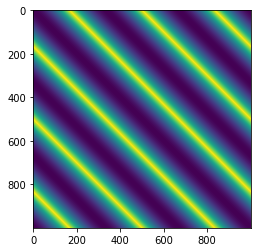

In [ ]:
plt.imshow( distmat_square(t[:,None],t[:,None]) )

A more memory efficient way (specially in high dimension $d$) way to compute the distance by expanding the squares.

In [ ]:
def distmat_square2(X, Y):
  X_sq = (X ** 2).sum(axis=-1)
  Y_sq = (Y ** 2).sum(axis=-1)
  cross_term = X.matmul(Y.T)
  return X_sq[:, None] + Y_sq[None, :] - 2 * cross_term

In [ ]:
t0 = time()
distmat_square(X, Y)
print(time() - t0)

t0 = time()
distmat_square2(X, Y)
print(time() - t0)

0.03390192985534668
0.10188770294189453


# Maximum Mean Discrepencies

When training ML model with point clouds, it is important to be able to compare to pair of clouds. A simple loss function is to use an MMD norm
$$
    \text{MMD}(X,Y) \triangleq
    \frac{1}{n^2} \sum_{i,i'} k(x_i,x_{i'}) 
    +
    \frac{1}{m^2} \sum_{j,j'} k(y_j,y_{j'})
    -2
    \frac{1}{nm} \sum_{i,j} k(x_i,y_{j}).
$$
We use here the energy distance kernel, so that MMD$(X,Y)$ is a dual Sobolev norm between the discrete measure $\frac{1}{n}\sum_i \delta_{x_i}$ and $\frac{1}{m}\sum_i \delta_{y_j}$
$$
  k(x,y) = -\|x-y\|.
$$

In [ ]:
def kernel(X,Y):
  return -torch.sqrt( distmat_square(X,Y) )

def MMD(X,Y):
  n = X.shape[0]
  m = Y.shape[0]
  a = torch.sum( kernel(X,X) )/n**2 + \
      torch.sum( kernel(Y,Y) )/m**2 - \
      2*torch.sum( kernel(X,Y) )/(n*m)
  return a.item()

In [ ]:
print( MMD(X,X) ) # should be 0
print( MMD(X,Y) ) # should be >0

0.0
7.224082946777344e-05


# Gradient flow with Pytorch

We compute a speed vector field to advances the particlesusing an interaction kernel of the form
$$
  v(X)_i = \frac{1}{n} \sum_j \psi(\|x_i-x_j\|^2) (x_j-x_i)
$$
Note that the evolution
$$
  \dot X = -v(X)
$$
is the Wasserstein gradient flow of the energy
$$
  \sum_{i,j} \phi(\|x_i-y_j\|^2 ).
$$
when defining $\psi(r)=4\phi'(r)$.

If $\phi$ is decreasing (resp. increasing), the flow is repulsive (resp. attractive).

In [ ]:
sigma = .1;
def psi(r):
  return torch.exp( -r/(2*sigma**2) )

In [ ]:
def Speed(X):
  return 2/X.shape[0] * 1/sigma**2 * torch.sum( psi(distmat_square(X,X))[:,:,None] * bc_diff( X[:,None,:] - X[None,:,:] ), axis=1 )

Discretize the evolution $\dot X = -v(X)$.

In [ ]:
if boundary=='no':
  tau = 1/500 # time step
else:
  tau = 1/200
niter = 200
save_per = 10 # periodicity of saving
Zsvg = torch.zeros((n,2,niter//save_per)) # to store all the intermediate time
Z = X
for it in progressbar.progressbar(range(niter)):
  if np.mod(it,save_per)==0:
    Zsvg[:,:,it//save_per] = Z.clone().detach() # for later display
  Z = bc_pos( Z - tau*Speed(Z) )

100% (200 of 200) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


Display the evolution.

In [ ]:
import ipywidgets as widgets
@widgets.interact(t=(0,niter//save_per-1))
def display_frame(t=0):
  s = t/(niter//save_per-1)
  plt.scatter(Zsvg[:,0,t], Zsvg[:,1,t], color=[s,0,1-s])
  plt.axis('equal')
  plt.axis([0,1,0,1])

interactive(children=(IntSlider(value=0, description='t', max=19), Output()), _dom_classes=('widget-interact',…

# Computing Gradient with Auto-diff

Instead of computing "by hand" the gradient of the interaction energy, one can directly rely on Pytorch auto-diff functionality. This simplifies coding and it reduces bugs in code.

In [ ]:
X.requires_grad = True
L = -1/X.shape[0] * torch.sum( psi(distmat_square(X,X)), axis=(0,1) )
[g] = torch.autograd.grad(L, [X])
# compare with the "by hand" computation
print( 'Difference "hand" vs. pytorch" : ' + str( torch.norm( g-Speed(X) ).item()  / torch.norm( g ).item() ) )

Difference "hand" vs. pytorch" : 1.5393619922631306e-07


# Computations using Keops

In order to speed up (by a factor 10 to 100) the evaluation of the kernel, it is possible to use [Keops](https://www.kernel-operations.io/keops/index.html), which allows one to define "lazy tensor". This both reduces the memory footprint (by evaluating the kernel on the fly) and accelerate the computation by a careful mapping of the tensor entries evaluations on the tiles of the GPU.

In [ ]:
!pip install pykeops[colab] > install.log

In [ ]:
import pykeops
import pykeops.torch as keops
pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_torch_bindings()    # perform the compilation

Cleaning /root/.cache/pykeops-1.5-cpython-37/...
[pyKeOps] Initializing build folder for dtype=float32 and lang=torch in /root/.cache/pykeops-1.5-cpython-37 ... done.
[pyKeOps] Compiling libKeOpstorch180bebcc11 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(SqNorm2(x - y),1)
       aliases: x = Vi(0,3); y = Vj(1,3); 
       dtype  : float32
... 
[pyKeOps] Compiling pybind11 template libKeOps_template_574e4b20be in /root/.cache/pykeops-1.5-cpython-37 ... done.
Done.

pyKeOps with torch bindings is working!



Compute the gradient of a kernel interaction.

In [ ]:
X.requires_grad = True
D = keops.Vi(X) - keops.Vj(X)
if boundary=='per':
  D1 = (D-.5).mod(1.0)-.5 # for periodic BC
else: 
  D1 = D
D2 = ( D1 ** 2 ).sum( dim=2 )
K = ( -D2 / (2*sigma**2) ).exp()
L = -1/X.shape[0] * (K.sum(dim=1)**1).sum()
[g] = torch.autograd.grad(L, [X])
# compare with the "by hand" computation
print( 'Difference "hand" vs. "keops+pytorch" : ' + str( torch.norm( g-Speed(X) ).item()  / torch.norm( g ).item() ) )

[pyKeOps] Compiling libKeOpstorchea57037698 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(Exp((Minus(Sum(Square((Mod(((Var(0,2,0) - Var(1,2,1)) - Var(2,1,2)), Var(3,1,2), IntCst(0)) - Var(4,1,2))))) / Var(5,1,2))),0)
       aliases: Var(0,2,0); Var(1,2,1); Var(2,1,2); Var(3,1,2); Var(4,1,2); Var(5,1,2); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorch17a5f3fca7 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Grad_WithSavedForward(Sum_Reduction(Exp((Minus(Sum(Square((Mod(((Var(0,2,0) - Var(1,2,1)) - Var(2,1,2)), Var(3,1,2), IntCst(0)) - Var(4,1,2))))) / Var(5,1,2))),0), Var(0,2,0), Var(6,1,0), Var(7,1,0))
       aliases: Var(0,2,0); Var(1,2,1); Var(2,1,2); Var(3,1,2); Var(4,1,2); Var(5,1,2); Var(6,1,0); Var(7,1,0); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorchfdfa2e7b49 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Grad_WithSavedForward(Sum_Reduction(Exp((Minus(Sum(Square((Mod(((Var(0,2,0) - Var(1,2,1

In [ ]:
Zsvg = torch.zeros((n,2,niter//save_per)) # to store all the intermediate time
Z = X
Z.requires_grad = True
for it in progressbar.progressbar(range(niter)):
  if np.mod(it,save_per)==0:
    Zsvg[:,:,it//save_per] = Z.clone().detach() # for later display
  D = keops.Vi(Z) - keops.Vj(Z)
  if boundary=='per':
    D1 = (D-.5).mod(1.0)-.5 # for periodic BC
  else: 
    D1 = D
  D2 = ( D1 ** 2 ).sum( dim=2 )
  K = ( -D2 / (2*sigma**2) ).exp()
  L = 1/X.shape[0] * (K.sum(dim=1)**1).sum() # There is a bug, I needed to add **1 here !!
  [g] = torch.autograd.grad(L, [Z])
  Z = bc_pos( Z + tau*g )

100% (200 of 200) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


In [ ]:
import ipywidgets as widgets
@widgets.interact(t=(0,niter//save_per-1))
def display_frame(t=0):
  s = t/(niter//save_per-1)
  plt.scatter(Zsvg[:,0,t], Zsvg[:,1,t], color=[s,0,1-s])
  plt.axis('equal')
  plt.axis([0,1,0,1])

interactive(children=(IntSlider(value=0, description='t', max=19), Output()), _dom_classes=('widget-interact',…